# Training and Validation Model

În acest notebook am implementat în mare parte clase personalizate pentru pipeline, pentru a automatiza procesele de prelucrare a datelor. Unele prelucrări le-am scos în afara pipeline-ului din motivul că așa este mai rapid.

După aceea, am antrenat diverse modele pentru a determina care este cel mai bun pentru acest dataset (modelele neutilizabile le-am șters din notebook).

În plus, pe lângă modelul principal, aș menționa că utilizez RandomForestRegressor pentru completarea valorilor NaN în coloanele rooms, surface_total și surface_covered.


In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

In [381]:
class CleanNaN(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str], fillna=None):
        self.cols = columns
        self.fillna = fillna

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if self.fillna is None:
            mask = X[self.cols].isna().all(axis=1)

            return X.loc[~mask].copy()

        elif self.fillna == "median":
            for col in self.cols:
                X[col] = X[col].fillna(X[col].median())

        else:
            for col in self.cols:
                X[col] = X[col].fillna(self.fillna)

        return X

In [382]:
class DropInutilColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str]):
        self.cols = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.cols, axis=1)

In [383]:
class ToDateTime(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str]):
        self.cols = columns

    def fit(self, X, y=None):
        return self

    def to_datetime(self, X, y=None):
        X = X.copy()

        for col in self.cols:
            X[col] = pd.to_datetime(X[col], errors="coerce")

        return X

    def transform(self, X):
        X = X.copy()

        X = self.to_datetime(X)
        X[self.cols] = X[self.cols].fillna(-1)
        X = self.to_datetime(X)

        return X

In [384]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(
        self, columns: list[str], encoder_type: str = "one-hot", new_values=None
    ):
        self.cols = columns
        self.type = encoder_type
        self.new_values = new_values
        self.encoder = OneHotEncoder(drop=None, sparse_output=False)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if self.type == "one-hot":
            encoded_data = self.encoder.fit_transform(X[self.cols])
            encoded_data = pd.DataFrame(
                encoded_data,
                columns=self.encoder.get_feature_names_out(self.cols),
                index=X.index,
            )

            X = pd.concat([X, encoded_data], axis=1)

            return X.drop(self.cols, axis=1)

        elif self.type == "manual":
            for col, value in zip(self.cols, self.new_values):
                X[col] = X[col].replace(value)

            return X

In [385]:
class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str], threshold: int, new_category: str):
        self.cols = columns
        self.threshold = (threshold,)
        self.new_category = new_category

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for col in self.cols:
            counts = X[col].value_counts()

            X[col] = X[col].map(
                lambda x: x if counts[x] >= self.threshold else self.new_category
            )
            X[col] = X[col].astype("category").cat.codes

        return X

In [386]:
class ConditionDrop(BaseEstimator, TransformerMixin):
    def __init__(self, columns, conditions, type: str = "drop"):
        self.cols = columns
        self.conditions = conditions
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for col, condition in zip(self.cols, self.conditions):
            if self.type == "drop":
                X = X.drop(X[condition(X, col)].index, axis=0)

            elif self.type == "drop-one":
                X = X.drop(X[condition(X, self.cols[0], self.cols[1])].index, axis=0)
                break

            elif self.type == "fill":
                X[col] = X[col].apply(condition)

            elif self.type == "setou":
                X.loc[condition(X, col), col] = 0

        return X

In [387]:
condition1 = lambda X, col: X[col] > 8
condition2 = lambda X, col: X[col] > 6
condition3 = lambda X, col: X[col] > 5
condition4 = lambda x: 0 if x < 0 else x
condition5 = lambda X, col: X[col] < 0
condition6 = lambda X, col1, col2: X[col1] > X[col2]

In [388]:
class Combine(BaseEstimator, TransformerMixin):
    def __init__(self, columns, type: str = "median"):
        self.cols = columns
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if self.type == "median":
            X[self.cols[0]] = X[self.cols].median(axis=1)
            X = X.drop(self.cols[1:], axis=1)

        return X

In [389]:
class CustomRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        colna,
        n_estimators,
        max_depth,
        min_samples_split,
        min_samples_leaf,
        max_features,
    ):
        self.colna = colna
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = 42
        self.n_jobs = -1

        self.model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state,
            n_jobs=self.n_jobs,
        )

    def fit(self, X, y):
        X, y = X.copy(), y.copy()
        notna_X = X[X[self.colna].notna().all(axis=1)]
        self.isna_X = X[y.isna()]
        X2 = notna_X.copy()
        y2 = y[X2.index]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X2, y2, test_size=0.3, random_state=42
        )

        self.model.fit(self.X_train, self.y_train)

        self.y_pred = self.model.predict(self.X_test)
        self.r2 = r2_score(self.y_test, self.y_pred)
        self.mae = mean_absolute_error(self.y_test, self.y_pred)
        self.mape = mean_absolute_percentage_error(self.y_test, self.y_pred)

        print(f"R2: {self.r2}; MAE: {self.mae}; MAPE: {self.mape};")
        print("---------")

        return self

    def predict(self, X):
        return self.model.predict(self.isna_X)

    def score(self, X, y):
        return self.model.score(X, y)

In [390]:
def predict_na(
    df: pd.DataFrame,
    targets: list[str],
    colna: list[str],
    n_estimators: int = 200,
    max_depth: int = None,
    min_samples_split: int = 5,
    min_samples_leaf: int = 1,
    max_features: int | float | str = "sqrt",
) -> pd.DataFrame:
    cdf = df.copy()

    notna_cdf = cdf[cdf[colna].notna().all(axis=1)]
    for t in tqdm(targets):
        isna_cdf = cdf[cdf[t].isna()]
        X = notna_cdf.drop(t, axis=1)
        y = notna_cdf[t]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1,
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print(f"R2: {r2}; MAE: {mae}; MAPE: {mape};")
        print("---------")

        X = isna_cdf.drop(t, axis=1)

        cdf.loc[isna_cdf.index, t] = model.predict(X)

    return cdf[targets]

In [391]:
def show_boxplots(df: pd.DataFrame, rows: int = 3, cols: int = 3):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, cols * 3))

    for i in tqdm(range(cols)):
        for i2, c in tqdm(enumerate(df.iloc[:, cols * i : cols * (i + 1)].columns)):
            axs[i2, i].boxplot(df[c])
            axs[i2, i].set_title(c)

    plt.tight_layout()
    plt.show()

In [392]:
pd.set_option("display.max_columns", 50)

In [393]:
df = pd.read_csv("data.csv")

In [394]:
X = df.drop(["price"], axis=1)
y = df["price"]

In [395]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [396]:
columns_for_clean = ['lat', 'lon', 'l3', 'l4', 'l5', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'currency', 'price_period']
inutil_columns = ['id', 'ad_type', 'l4', 'l5', 'l6', 'title', 'description', 'price_period']
date_columns = ['start_date', 'end_date', 'created_on']
for_one_hot = ['l1', 'property_type']
for_manual, values = ['operation_type'], [{
    'Venta': 0,
    'Alquiler': 1,
    'Alquiler temporal': 2
}]
fillna_columns = ['currency']
for_manual2, values2 = ['currency'], [{
    'USD': 1,
    'ARS': 2,
    'UYU': 3,
    'PEN': 4
}]
categorize_columns, threshold, new_category = ['l2'], 2000, 'Other'
fillna_columns2 = ['l3']
categorize_columns2, threshold2, new_category2 = ['l3'], 600, 'Other'
condition_columns, conditions = ['rooms', 'bedrooms', 'bathrooms'], [condition1, condition2, condition3]
condition_columns2, conditions2 = ['bedrooms'], [condition4]
combine_median_columns = ['rooms', 'bedrooms', 'bathrooms']
fill_median_columns = ['lat', 'lon']
condition_columns3, conditions3 = ['surface_total', 'surface_covered'], [condition5, condition5]
condition_columns4, conditions4 = ['surface_covered', 'surface_total'], [condition6, condition6]


pipeline = Pipeline([
    ('cleanna', CleanNaN(columns=columns_for_clean)),
    ('drop_inutil', DropInutilColumns(columns=inutil_columns)),
    ('convert_date', ToDateTime(columns=date_columns)),
    ('one_hot_encoder', Preprocessor(columns=for_one_hot)),
    ('manual_encoder', Preprocessor(columns=for_manual, encoder_type='manual', new_values=values)),
    ('fillna1', CleanNaN(fillna_columns, 0)),
    ('manual_encoder2', Preprocessor(columns=for_manual2, encoder_type='manual', new_values=values2)),
    ('categorize', Categorize(columns=categorize_columns, threshold=threshold, new_category=new_category)),
    ('fillna2', CleanNaN(fillna_columns2, 'Missing')),
    ('categorize2', Categorize(columns=categorize_columns2, threshold=threshold2, new_category=new_category2)),
    ('condition_drop', ConditionDrop(columns=condition_columns, conditions=conditions)),
    ('condition_drop2', ConditionDrop(columns=condition_columns2, conditions=conditions2, type='fill')),
    ('combine_median', Combine(columns=combine_median_columns)),
    ('fillna3', CleanNaN(fill_median_columns, 'median')),
    ('condition_drop3', ConditionDrop(columns=condition_columns3, conditions=conditions3, type='setou')),
    ('condition_drop4', ConditionDrop(columns=condition_columns4, conditions=conditions4, type='drop-one')),
])

In [397]:
def procesing_y(X, y):
    X, y = X.copy(), y.copy()
    y = y[X.index]

    X = X.drop(y[y.isna()].index, axis=0)
    y = y.drop(y[y.isna()].index, axis=0)

    X["surface_total_missing"] = X["surface_total"].isna().astype(int)
    X["surface_covered_missing"] = X["surface_covered"].isna().astype(int)

    temp_X = X.iloc[:, 3:]
    temp_X["price"] = y
    X[["rooms"]] = predict_na(
        temp_X, ["rooms"], colna=["rooms", "surface_total", "surface_covered"]
    )

    temp_X = X.iloc[:, 3:]
    temp_X["price"] = y
    X[["surface_covered"]] = predict_na(
        temp_X,
        ["surface_covered"],
        colna=["surface_total", "surface_covered"],
        n_estimators=50,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
    )

    temp_X = X.iloc[:, 3:]
    temp_X["price"] = y
    X[["surface_total"]] = predict_na(
        temp_X,
        ["surface_total"],
        colna=["surface_total", "surface_covered"],
        n_estimators=50,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="sqrt",
    )

    return X.iloc[:, 5:], y

In [398]:
def procesing(X, y):
    X, y = procesing_y(X, y)

    # For loops de mai jos elimină outliers din coloane
    for col in ["surface_total", "surface_covered", "rooms", "l2", "l3"]:
        low, high = X[col].quantile([0.01, 0.99])
        X = X[(X[col] >= low) & (X[col] <= high)]
        y = y.loc[X.index]

    for col in ["surface_total", "surface_covered", "rooms"]:
        X[col] = np.log1p(X[col])
        y = np.log1p(y)

    for i in range(5):
        y_log = np.log1p(y)
        lo, hi = np.percentile(y_log, [1, 99])

        mask = (y_log >= lo) & (y_log <= hi)
        X, y = X[mask], y[mask]

    return X, y

In [399]:
X_val_save = pipeline.fit_transform(X=X_val)

C:\Users\Home\AppData\Local\Temp\ipykernel_3756\80899401.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].replace(value)


In [400]:
X_val_save, y_val_save = procesing(X_val_save, y_val)

  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.749544566816774; MAE: 0.35957124254760964; MAPE: 0.18412684744868146;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.4794956536133169; MAE: 57.37837010787321; MAPE: 1.8831264535791812;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.6232880285866722; MAE: 297.09540714615275; MAPE: 0.7745548519787506;
---------


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


In [401]:
X_test_save = pipeline.transform(X=X_test)

C:\Users\Home\AppData\Local\Temp\ipykernel_3756\80899401.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].replace(value)
c:\Users\Home\Desktop\Katsuryoku\Work\Sigmoid\Tech\Examination\Exam_14_04_2025_3\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [402]:
X_test_save, y_test_save = procesing(X_test_save, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.7431523415473962; MAE: 0.36627229621004553; MAPE: 0.18820968892594744;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.2294135852289647; MAE: 62.23518529033511; MAPE: 1.6694722146207965;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.567243978018642; MAE: 283.41975123206635; MAPE: 0.8858454804369688;
---------


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [403]:
X_train_proc = pipeline.transform(X_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_3756\80899401.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].replace(value)
c:\Users\Home\Desktop\Katsuryoku\Work\Sigmoid\Tech\Examination\Exam_14_04_2025_3\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [404]:
X_train_proc, y_train_proc = procesing(X_train_proc, y_train)

  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.7788934534472245; MAE: 0.3201602537882507; MAPE: 0.1603703747398276;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.5530709053201424; MAE: 51.27570027672057; MAPE: 10337490270042.492;
---------


  0%|          | 0/1 [00:00<?, ?it/s]

R2: 0.6481116282010992; MAE: 232.85055559250011; MAPE: 0.7187305796019346;
---------


100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


5it [00:00, 24.93it/s]00:00<?, ?it/s]
5it [00:00, 19.37it/s]00:00<00:00,  4.36it/s]
5it [00:00, 25.25it/s]00:00<00:00,  3.77it/s]
5it [00:00, 25.38it/s]00:00<00:00,  4.06it/s]
3it [00:00, 25.68it/s]00:00<00:00,  4.23it/s]
100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


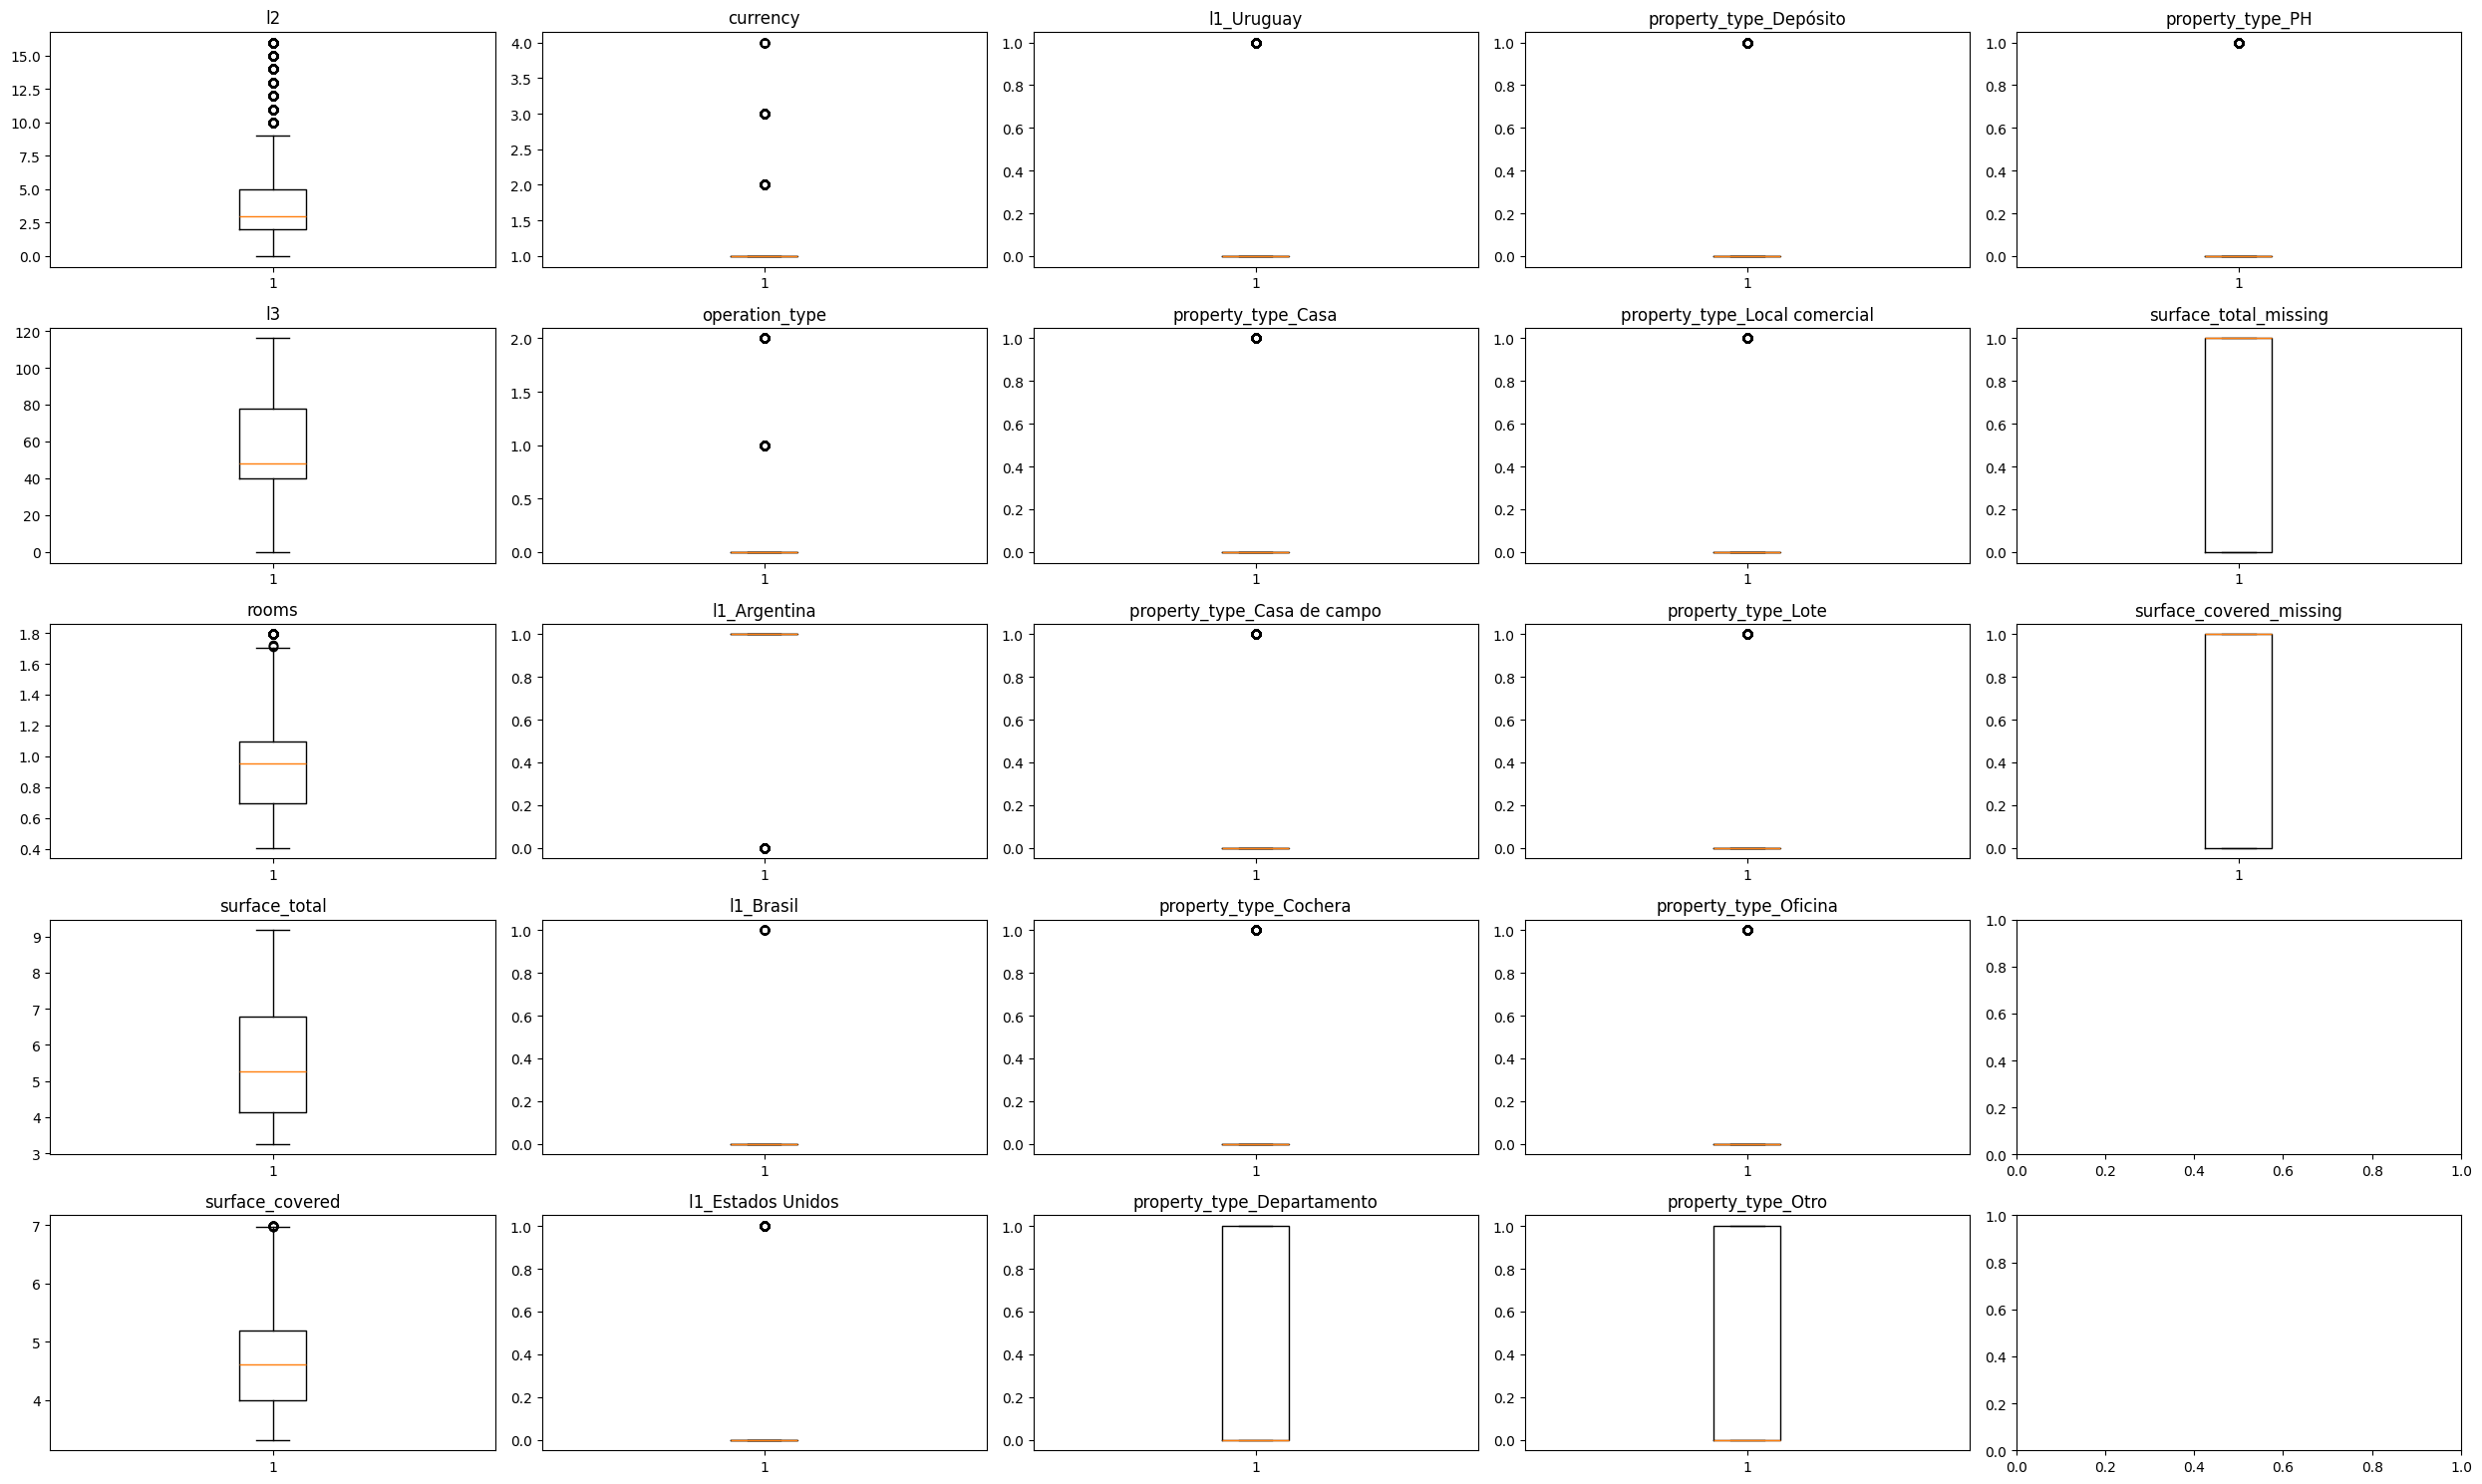

In [405]:
show_boxplots(X_train_proc, rows=5, cols=5)

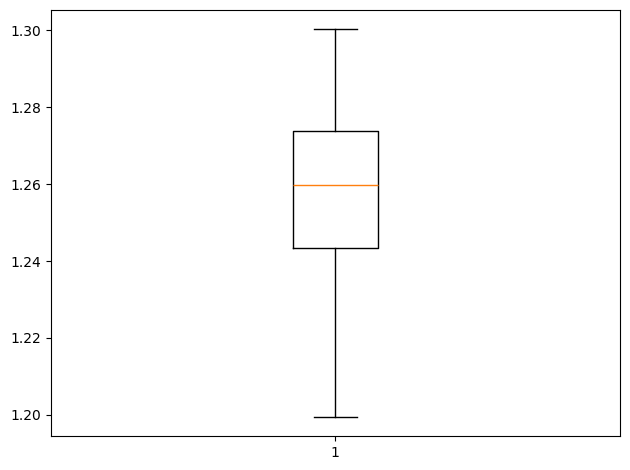

In [406]:
plt.boxplot(y_train_proc)
plt.tight_layout()
plt.show()

In [407]:
def search_hyper_parameters():
    lgb = LGBMRegressor(
        n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1
    )

    param_dist = {
        "n_estimators": [100, 200, 300],
        "num_leaves": [31, 63, 127],
        "max_depth": [5, 10, 15, -1],
        "min_child_samples": [10, 20, 50, 100],
        "feature_fraction": [0.6, 0.8, 1.0],
        "bagging_fraction": [0.6, 0.8, 1.0],
        "bagging_freq": [0, 5, 10],
        "lambda_l1": [0, 0.1, 1.0, 5.0],
        "lambda_l2": [0, 0.1, 1.0, 5.0],
        "learning_rate": [0.01, 0.05, 0.09],
    }

    search = RandomizedSearchCV(
        estimator=lgb,
        param_distributions=param_dist,
        n_iter=30,
        scoring="neg_root_mean_squared_error",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=2,
    )

    X_tr = X_train_proc
    y_tr = np.log1p(y_train_proc)

    search.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val_save, np.log1p(y_val_save))],
        eval_metric="rmse",
        callbacks=[early_stopping(stopping_rounds=20), log_evaluation(period=0)],
    )

    print("Best RMSE (log-target):", -search.best_score_)
    print("Best params:", search.best_params_)

    best = search.best_estimator_
    y_pred = np.expm1(best.predict(X_test_save))
    rmse = np.sqrt(mean_squared_error(y_test_save, y_pred))
    print("RMSE final pe val:", rmse)

Testarea la modelă rapid


In [408]:
model = LGBMRegressor(
    **{
        "num_leaves": 127,
        "n_estimators": 200,
        "min_child_samples": 50,
        "max_depth": -1,
        "learning_rate": 0.09,
        "lambda_l2": 5.0,
        "lambda_l1": 0,
        "feature_fraction": 0.6,
        "bagging_freq": 5,
        "bagging_fraction": 1.0,
    }
)
model.fit(
    X_train_proc,
    np.log1p(y_train_proc),
    eval_set=[(X_val_save, np.log1p(y_val_save))],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=20), log_evaluation(period=0)],
)
y_pred = np.expm1(model.predict(X_val_save))
rmse = np.sqrt(mean_squared_error(y_val_save, y_pred))
print("RMSE după cap-and-floor + log:", rmse)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 0.00495656	valid_0's l2: 2.45675e-05
RMSE după cap-and-floor + log: 0.011154614196529479


In [409]:
y_pred = np.expm1(model.predict(X_test_save))
rmse = np.sqrt(mean_squared_error(y_test_save, y_pred))
print("RMSE după cap-and-floor + log:", rmse)

RMSE după cap-and-floor + log: 0.011636146983751074


In [410]:
class Regressor:
    def __init__(self):
        self.model = LGBMRegressor(
            **{
                "num_leaves": 127,
                "n_estimators": 200,
                "min_child_samples": 50,
                "max_depth": -1,
                "learning_rate": 0.09,
                "lambda_l2": 5.0,
                "lambda_l1": 0,
                "feature_fraction": 0.6,
                "bagging_freq": 5,
                "bagging_fraction": 1.0,
            }
        )

    def fit(self, X_train, y_train, X_val, y_val):
        self.X_train, self.y_train, self.X_val, self.y_val = (
            X_train,
            y_train,
            X_val,
            y_val,
        )

        self.model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_val, np.log1p(y_val))],
            eval_metric="rmse",
            callbacks=[early_stopping(stopping_rounds=20), log_evaluation(period=0)],
        )

    def validation_score(self):
        y_pred = np.expm1(self.model.predict(self.X_val))
        rmse = np.sqrt(mean_squared_error(self.y_val, y_pred))

        return rmse

    def score(self, X_test, y_test):
        y_pred = np.expm1(self.model.predict(X_test))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        return rmse

In [411]:
regressor = Regressor()
regressor.fit(X_train_proc, y_train_proc, X_val_save, y_val_save)
print(regressor.validation_score())
print(regressor.score(X_test_save, y_test_save))

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 0.00495656	valid_0's l2: 2.45675e-05
0.011154614196529479
0.011636146983751074


Am ajuns la precizia modelului destul de bună, aș ridicaua mai tare, dar deja se apropie deadline.
